In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn_image as isns

import torch

from config import Environment
from denoising.data.utils import load_grayscale

isns.set_context('notebook')  # this will create thicker lines and larger fonts than usual
isns.set_image(cmap='gray', despine=True)  # set the colormap and despine the axes

In [3]:
print('torch ' + torch.__version__)

torch 2.6.0+cu124


In [4]:
# загружаем переменные окружения
env = Environment(_env_file='../env')

# Теорема о свертке с помощью FFT

In [76]:
from scipy import ndimage
from scipy.signal.windows import gaussian

In [77]:
def dft2d(x: np.ndarray, vis: bool = False) -> np.ndarray:
    fft = np.fft.fft2(x)
    fft_centered = np.fft.fftshift(fft)
    if vis:
        return np.log(1 + np.abs(fft_centered))
    return fft_centered


def conv_dft2d(
    x_src: np.ndarray, w: np.ndarray, padding: str | None = 'reflect'
) -> np.ndarray | torch.Tensor:
    x = np.copy(x_src)

    # apply padding
    if padding is not None:
        pad_width = [(w.shape[0], w.shape[0]), (w.shape[1], w.shape[1])] + [(0, 0)] * (x.ndim - 2)
        x = np.pad(x, pad_width, mode=padding)

    w_large = np.zeros_like(x)
    w_large[: w.shape[0], : w.shape[1], ...] = w

    x_fft = dft2d(x)
    w_fft = dft2d(w_large)

    convolved_fft = x_fft * w_fft

    res = np.fft.ifft2(np.fft.ifftshift(convolved_fft)).real

    # pad back
    if padding is not None:
        slices = []
        for p1, p2 in pad_width:
            if p1 == p2 == 0:
                slices.append(slice(None))
                continue
            slices.append(slice(p1, -p2))
        res = res[tuple(slices)]

    return res

In [78]:
def gauss_filter_kernel(sigma, kernel_size=50, norm=True):
    gkern1d = gaussian(kernel_size, std=sigma).reshape(kernel_size, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    if norm:
        gkern2d /= gkern2d.sum()
    return gkern2d

In [90]:
def diff_stats(a, b):
    if isinstance(a, np.ndarray):
        diff = np.abs(a - b)
    else:
        diff = torch.abs(a - b)
    return diff.sum(), diff.max(), diff.mean()

In [79]:
image = load_grayscale(env.data / 'lena.png') / 255.0
kernel = gauss_filter_kernel(3)

conv_scipy = ndimage.convolve(image, kernel)
conv_dft = conv_dft2d(image, kernel)

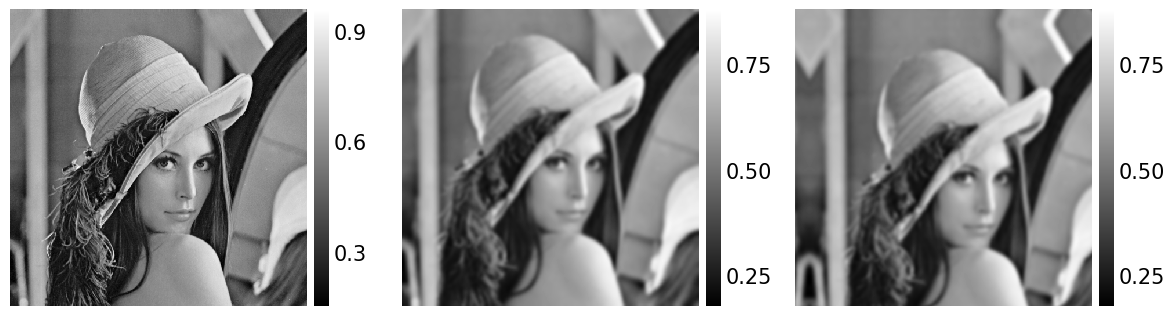

In [81]:
_ = isns.ImageGrid(
    [
        # check dft and kernel
        # image,
        # dft2d(image, True),
        # kernel,
        # check dft convolution
        image,
        conv_scipy,
        conv_dft,
    ],
    height=4,
)

In [91]:
diff_stats(conv_scipy, conv_dft)

(np.float64(36871.746906608896),
 np.float64(0.6476715408998672),
 np.float64(0.140654552103458))

# С помощью Separable DHT

In [6]:
from denoising.dht import (
    sdht2d,
    isdht2d,
    conv2d_sdht,
)

In [7]:
image = load_grayscale(env.data / 'lena.png') / 255.0

In [8]:
# conv_dht = conv2d_sdht(image, kernel)

# _ = isns.ImageGrid(
#     [
#         # validate dht-idht
#         # image,
#         # sdht2d(image),  # not suited for visualization
#         # isdht2d(sdht2d(image)),
#         # validate convolution theorem
#         image,
#         conv_scipy,
#         conv_dht,
#     ],
#     height=4,
# )

In [9]:
# diff_stats(image, isdht2d(sdht2d(image)))

In [10]:
# diff_stats(conv_scipy, conv_dht)

In [11]:
# diff_stats(conv_dft, conv_dht)

In [100]:
def fft2d(x: np.ndarray | torch.Tensor) -> np.ndarray | torch.Tensor:
    if isinstance(x, np.ndarray):
        return np.fft.fftshift(np.fft.fft2(x))
    return torch.fft.fftshift(torch.fft.fft2(x))


def ifft2d(x: np.ndarray | torch.Tensor) -> np.ndarray | torch.Tensor:
    if isinstance(x, np.ndarray):
        return np.fft.ifft2(np.fft.ifftshift(x)).real
    return torch.fft.ifft2(torch.fft.ifftshift(x)).real

In [17]:
def conv_fft(x, y):
    def fft(c):
        # return np.fft.fft2(c)
        return np.fft.fftshift(np.fft.fft2(c))

    convolved_fft = fft(x) * fft(y)
    return np.fft.ifft2(np.fft.ifftshift(convolved_fft)).real


# version without padding
def conv_dht(x, w):
    x_dht = sdht2d(x)
    w_dht = sdht2d(w)

    x_dht_flipy = flip(x_dht, axes=1)
    w_dht_flipy = flip(w_dht, axes=1)

    z_dht = (
        even(x_dht) * even(w_dht)
        - odd(x_dht_flipy) * odd(w_dht_flipy)
        + even(x_dht_flipy) * odd(w_dht)
        + odd(x_dht) * even(w_dht_flipy)
    )
    z = isdht2d(z_dht)
    return z

In [18]:
a = np.ones((5, 5))
b = np.copy(a)

In [19]:
conv_fft(a, b), conv2d_dht(a, b, padding=None)

(array([[25., 25., 25., 25., 25.],
        [25., 25., 25., 25., 25.],
        [25., 25., 25., 25., 25.],
        [25., 25., 25., 25., 25.],
        [25., 25., 25., 25., 25.]]),
 array([[25., 25., 25., 25., 25.],
        [25., 25., 25., 25., 25.],
        [25., 25., 25., 25., 25.],
        [25., 25., 25., 25., 25.],
        [25., 25., 25., 25., 25.]]))

# Теперь на torch

In [12]:
def dft2d_torch(x: torch.Tensor, vis: bool = False, norm: str = 'forward') -> torch.Tensor:
    fft = torch.fft.fft2(x, norm=norm)
    fft_centered = torch.fft.fftshift(fft)
    if vis:
        n = x.size()[-2:].numel()
        return torch.log(1 + torch.abs(fft_centered) * n)
    return fft_centered


def conv_dft2d_torch(
    x_src: torch.Tensor, w: torch.Tensor, padding: str | None = 'reflect'
) -> np.ndarray | torch.Tensor:
    x = x_src.clone()

    # apply padding
    if padding is not None:
        x = x.unsqueeze(0)
        pad = (w.shape[1], w.shape[1], w.shape[0], w.shape[0])
        x = torch.nn.functional.pad(x, pad, mode=padding).squeeze()

    w_large = torch.zeros_like(x)
    w_large[: w.shape[0], : w.shape[1], ...] = w

    x_fft = dft2d_torch(x, norm='forward')
    w_fft = dft2d_torch(w_large, norm='backward')

    convolved_fft = x_fft * w_fft

    res = torch.fft.ifft2(torch.fft.ifftshift(convolved_fft), norm='forward').real

    # slice after padding
    if padding is not None:
        res = res[..., w.shape[0]:-w.shape[0], w.shape[1]:-w.shape[1]]

    return res

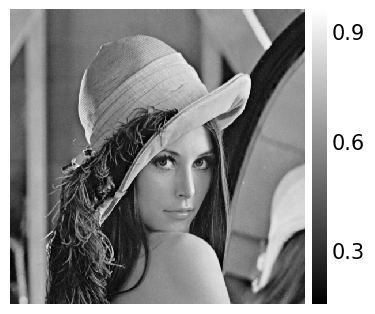

In [13]:
image = torch.Tensor(load_grayscale(env.data / 'lena.png') / 255.0)
# kernel = torch.Tensor(gauss_filter_kernel(3))
# conv_dft_t = conv_dft2d_torch(image, kernel)

_ = isns.ImageGrid(
    [
        # check dft and kernel
        image,
        # dft2d_torch(image, True),
        # kernel,
        # check dft convolution
        # image,
        # conv_dft_t,
    ],
    height=4,
)

In [9]:
def even(x: torch.Tensor) -> torch.Tensor:
    return (x + torch.flip(x, (-2, -1))) / 2


def odd(x: torch.Tensor) -> torch.Tensor:
    return (x - torch.flip(x, (-2, -1))) / 2

In [23]:
def dht2d(x, vis: bool = False):
    fft = torch.fft.fft2(x, norm='backward')
    if vis:
        # fft = torch.log(1 + torch.fft.fftshift(fft))
        fft = torch.log(1 + fft)
    return fft.real - fft.imag


def idht2d(x):
    fft = torch.fft.fft2(x, norm='forward')
    return fft.real - fft.imag


def conv_dht2d_torch(
    x_src: torch.Tensor, w: torch.Tensor, padding: str | None = 'reflect'
) -> np.ndarray | torch.Tensor:
    x = x_src.clone()

    # apply padding
    if padding is not None:
        x = x.unsqueeze(0)
        pad = (w.shape[1], w.shape[1], w.shape[0], w.shape[0])
        x = torch.nn.functional.pad(x, pad, mode=padding).squeeze()

    w_large = torch.zeros_like(x)
    w_large[: w.shape[0], : w.shape[1], ...] = w    
    
    x_dht = dht2d(x)
    w_dht = dht2d(w_large)

    x_dht_flipy = torch.flip(x_dht, (-1,))
    w_dht_flipy = torch.flip(w_dht, (-1,))

    z_dht = (
        even(x_dht) * even(w_dht)
        - odd(x_dht_flipy) * odd(w_dht_flipy)
        + even(x_dht_flipy) * odd(w_dht)
        + odd(x_dht) * even(w_dht_flipy)
    )
    res = idht2d(z_dht)

    # slice after padding
    if padding is not None:
        res = res[..., w.shape[0]:-w.shape[0], w.shape[1]:-w.shape[1]]

    return res

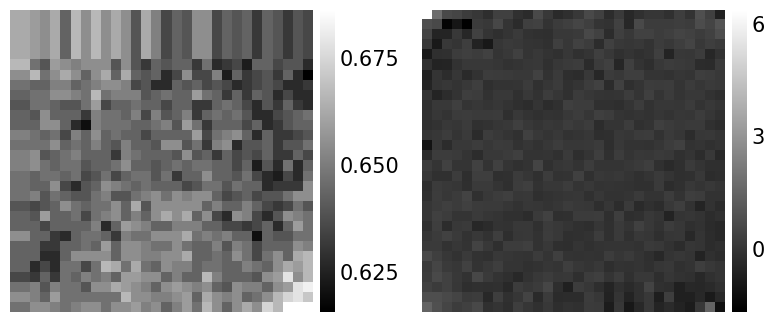

In [29]:
# kernel = torch.Tensor(gauss_filter_kernel(3))
# conv_dht_t = conv_dht2d_torch(image, kernel, padding=None)

_ = isns.ImageGrid(
    [
        # check dht
        image,
        dht2d(image, vis=True),
        # idht2d(dht2d(image)),
        # check dht convolution
        # image,
        # conv_dht_t,
    ],
    height=4,
)